## Tasks performed: 1) ABC Analysis 2) Reorder Point Analysis 3) Lead Time Analysis
## Demand forecasting is performed in other file with streamlit hosting

# Importing required Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

# Loading and Preprocessing Data

In [2]:
sales=pd.read_csv(r'D:\Slooze Dataset\slooze_challenge\SalesFINAL12312016.csv')
purchases = pd.read_csv(r'D:\Slooze Dataset\slooze_challenge\PurchasesFINAL12312016.csv')

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   InventoryId     1048575 non-null  object 
 1   Store           1048575 non-null  int64  
 2   Brand           1048575 non-null  int64  
 3   Description     1048575 non-null  object 
 4   Size            1048575 non-null  object 
 5   SalesQuantity   1048575 non-null  int64  
 6   SalesDollars    1048575 non-null  float64
 7   SalesPrice      1048575 non-null  float64
 8   SalesDate       1048575 non-null  object 
 9   Volume          1048575 non-null  int64  
 10  Classification  1048575 non-null  int64  
 11  ExciseTax       1048575 non-null  float64
 12  VendorNo        1048575 non-null  int64  
 13  VendorName      1048575 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 112.0+ MB


In [4]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372474 entries, 0 to 2372473
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   InventoryId     object 
 1   Store           int64  
 2   Brand           int64  
 3   Description     object 
 4   Size            object 
 5   VendorNumber    int64  
 6   VendorName      object 
 7   PONumber        int64  
 8   PODate          object 
 9   ReceivingDate   object 
 10  InvoiceDate     object 
 11  PayDate         object 
 12  PurchasePrice   float64
 13  Quantity        int64  
 14  Dollars         float64
 15  Classification  int64  
dtypes: float64(2), int64(6), object(8)
memory usage: 289.6+ MB


## Converting Datatypes of Date columns

In [5]:
#for sales data
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'], errors='coerce')

#for purchase data
date_cols = ["PODate", "ReceivingDate", "InvoiceDate", "PayDate"]
for col in date_cols:
    purchases[date_cols] = purchases[date_cols].apply(pd.to_datetime, errors='coerce')


# 1) ABC ANALYSIS (based on total revenue of each item)

## i) Grouping data on  "InventoryId", "Description"  to get aggregate sales...followed by sorting in decreasing order

In [6]:
abc = sales.groupby(["InventoryId", "Description" ] , as_index=False).agg(
    total_revenue = ("SalesDollars", "sum"))

In [7]:
# Sort by revenue
abc = abc.sort_values("total_revenue", ascending=False).reset_index(drop=True)

In [8]:
abc.head()

,InventoryId,Description,total_revenue
0,34_PITMERDEN_3545,Ketel One Vodka,25325.57
1,34_PITMERDEN_4261,Capt Morgan Spiced Rum,23199.45
2,15_WANBORNE_8068,Absolut 80 Proof,20406.90
3,14_BROMWICH_4261,Capt Morgan Spiced Rum,18691.50
4,10_HORNSEY_4261,Capt Morgan Spiced Rum,18400.64


In [9]:
abc.count()

InventoryId      170131
Description      170131
total_revenue    170131
dtype: int64

## ii) Creating cumulative revenue and cumulative percent for aggregated revenue

In [10]:
# Cumulative percentage
abc["cum_revenue"] = abc["total_revenue"].cumsum()


In [11]:
abc.head(5)

,InventoryId,Description,total_revenue,cum_revenue
0,34_PITMERDEN_3545,Ketel One Vodka,25325.57,25325.57
1,34_PITMERDEN_4261,Capt Morgan Spiced Rum,23199.45,48525.02
2,15_WANBORNE_8068,Absolut 80 Proof,20406.90,68931.92
3,14_BROMWICH_4261,Capt Morgan Spiced Rum,18691.50,87623.42
4,10_HORNSEY_4261,Capt Morgan Spiced Rum,18400.64,106024.06


In [12]:
#Cumulative percent
abc["cum_percent"] = abc["cum_revenue"] / abc["total_revenue"].sum() * 100

In [13]:
abc.head()

,InventoryId,Description,total_revenue,cum_revenue,cum_percent
0,34_PITMERDEN_3545,Ketel One Vodka,25325.57,25325.57,0.076421
1,34_PITMERDEN_4261,Capt Morgan Spiced Rum,23199.45,48525.02,0.146427
2,15_WANBORNE_8068,Absolut 80 Proof,20406.90,68931.92,0.208006
3,14_BROMWICH_4261,Capt Morgan Spiced Rum,18691.50,87623.42,0.264409
4,10_HORNSEY_4261,Capt Morgan Spiced Rum,18400.64,106024.06,0.319934


In [14]:
abc.tail()

,InventoryId,Description,total_revenue,cum_revenue,cum_percent
170126,61_AETHELNEY_8495,Capt Morgan White Pineapple,0.99,3.313937e+07,99.999991
170127,52_GRAYCOTT_4857,Skyy Infusions Grapefuit,0.99,3.313937e+07,99.999994
170128,24_PALPERROTH_3568,Pearl Cucumber Vodka,0.99,3.313937e+07,99.999997
170129,11_CARDEND_5287,Dr McGillicuddy's Vanilla,0.49,3.313937e+07,99.999999
170130,6_GOULCREST_5287,Dr McGillicuddy's Vanilla,0.49,3.313938e+07,100.000000


## iii)Preparing and applying ABC criteria to classify product

In [15]:
# ABC classification rule
def classify(p):
    if p <= 70:
        return "A"
    elif p <= 90:
        return "B"
    else:
        return "C"

In [16]:
abc['ABC_class']=abc['cum_percent'].apply(classify)

In [17]:
abc.head()

,InventoryId,Description,total_revenue,cum_revenue,cum_percent,ABC_class
0,34_PITMERDEN_3545,Ketel One Vodka,25325.57,25325.57,0.076421,A
1,34_PITMERDEN_4261,Capt Morgan Spiced Rum,23199.45,48525.02,0.146427,A
2,15_WANBORNE_8068,Absolut 80 Proof,20406.90,68931.92,0.208006,A
3,14_BROMWICH_4261,Capt Morgan Spiced Rum,18691.50,87623.42,0.264409,A
4,10_HORNSEY_4261,Capt Morgan Spiced Rum,18400.64,106024.06,0.319934,A


In [18]:
num_A=len(abc[abc['ABC_class']=='A'])
num_B=len(abc[abc['ABC_class']=='B'])
num_C=len(abc[abc['ABC_class']=='C'])

## iv) ABC Classification summary and Visualisation

In [19]:
print("ABC Classification Summary")
print("----------------------------")
print(f"Class A Products: {num_A}")
print(f"Class B Products: {num_B}")
print(f"Class C Products: {num_C}")

ABC Classification Summary
----------------------------
Class A Products: 36801
Class B Products: 48205
Class C Products: 85125


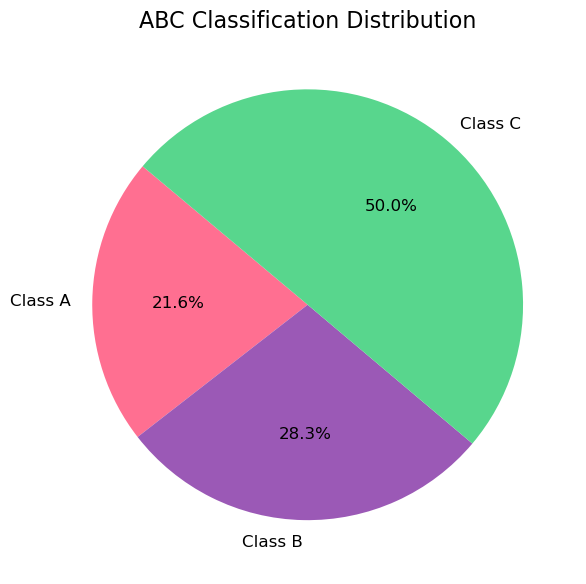

In [20]:
labels = ['Class A', 'Class B', 'Class C']
sizes = [num_A, num_B, num_C]
colors = ['#FF6F91', '#9B59B6',  '#58D68D']  

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',textprops={'color':'black', 'fontsize':12}, startangle=140)
plt.title("ABC Classification Distribution", color='black', fontsize=16)
plt.tight_layout()
plt.show()


# 2. Reorder Point Analysis

## i) Preparing daily demand data by aggregating sales quantity with grouping by 'InventoryId', 'Description', 'SalesDate'

In [21]:
daily_demand = (
    sales.groupby(['InventoryId', 'Description', 'SalesDate'], as_index=False)['SalesQuantity']
         .sum()
         .rename(columns={'SalesQuantity': 'daily_demand'})
)

In [22]:
daily_demand.head()

,InventoryId,Description,SalesDate,daily_demand
0,10_HORNSEY_1000,Goslings Dark'n Stormy VAP,2016-01-29,1
1,10_HORNSEY_1001,Bailey's 50mL 4 Pack,2016-01-01,4
2,10_HORNSEY_1001,Bailey's 50mL 4 Pack,2016-01-02,5
3,10_HORNSEY_1001,Bailey's 50mL 4 Pack,2016-01-04,2
4,10_HORNSEY_10030,Pacifico Sur Pnt Nr Rsv,2016-02-13,2


In [23]:
len(daily_demand)

1048575

## ii) Preparing Statistical data for daily demand : Mean and std dev

In [24]:
# Demand stats per product
demand_stats = (
    daily_demand.groupby(['InventoryId', 'Description'])
                .agg(
                    avg_daily_demand=('daily_demand', 'mean'),
                    std_daily_demand=('daily_demand', 'std')
                )
                .reset_index()
)


In [25]:
len(demand_stats)

170131

In [26]:
demand_stats.head()

,InventoryId,Description,avg_daily_demand,std_daily_demand
0,10_HORNSEY_1000,Goslings Dark'n Stormy VAP,1.000000,NaN
1,10_HORNSEY_1001,Bailey's 50mL 4 Pack,3.666667,1.527525
2,10_HORNSEY_10030,Pacifico Sur Pnt Nr Rsv,2.000000,NaN
3,10_HORNSEY_1005,Maker's Mark Combo Pack,1.000000,0.000000
4,10_HORNSEY_10057,Rocca delle Macie Sasyr Tscn,12.000000,NaN


In [27]:
demand_stats.isna().sum()

InventoryId             0
Description             0
avg_daily_demand        0
std_daily_demand    34583
dtype: int64

In [28]:
demand_stats['std_daily_demand'].fillna(0,inplace=True)   #filling std deviation null values with 0

In [29]:
demand_stats.head()

,InventoryId,Description,avg_daily_demand,std_daily_demand
0,10_HORNSEY_1000,Goslings Dark'n Stormy VAP,1.000000,0.000000
1,10_HORNSEY_1001,Bailey's 50mL 4 Pack,3.666667,1.527525
2,10_HORNSEY_10030,Pacifico Sur Pnt Nr Rsv,2.000000,0.000000
3,10_HORNSEY_1005,Maker's Mark Combo Pack,1.000000,0.000000
4,10_HORNSEY_10057,Rocca delle Macie Sasyr Tscn,12.000000,0.000000


## iii) Using purchase data to get lead days 

In [30]:
pur=purchases.copy()

In [31]:
pur.head()

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1


In [32]:
pur['lead_days'] = (pur['ReceivingDate'] - pur['PODate']).dt.days


In [33]:
pur.head()

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification,lead_days
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1,12
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1,10
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1,11
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1,10
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1,9


## iv) Preparing statistical data for lead days

In [34]:
lead_stats = (
    pur.groupby(['InventoryId', 'Description'])
             .agg(
                 avg_lead_time=('lead_days', 'mean'),
                 std_lead_time=('lead_days', 'std'),
                 total_orders=('lead_days', 'count')
             )
             .reset_index()
)

In [35]:
lead_stats.head()

,InventoryId,Description,avg_lead_time,std_lead_time,total_orders
0,10_HORNSEY_1001,Bailey's 50mL 4 Pack,5.500000,0.707107,2
1,10_HORNSEY_1003,Crown Royal +2 Reusable Cups,7.692308,1.931520,13
2,10_HORNSEY_10030,Pacifico Sur Pnt Nr Rsv,9.500000,3.535534,2
3,10_HORNSEY_1004,Jim Beam w/2 Rocks Glasses,9.000000,NaN,1
4,10_HORNSEY_10057,Rocca delle Macie Sasyr Tscn,9.000000,NaN,1


In [36]:
lead_stats.isnull().sum()

InventoryId          0
Description          0
avg_lead_time        0
std_lead_time    56671
total_orders         0
dtype: int64

In [37]:
lead_stats['std_lead_time'].fillna(0,inplace=True)
lead_stats.isnull().sum()

InventoryId      0
Description      0
avg_lead_time    0
std_lead_time    0
total_orders     0
dtype: int64

## v) Merging Daily demand and Lead time data 

In [38]:
#Merge Demand + Lead Time
rop_df = demand_stats.merge(lead_stats, on=['InventoryId', 'Description'], how='inner')
rop_df.head()


,InventoryId,Description,avg_daily_demand,std_daily_demand,avg_lead_time,std_lead_time,total_orders
0,10_HORNSEY_1001,Bailey's 50mL 4 Pack,3.666667,1.527525,5.500,0.707107,2
1,10_HORNSEY_10030,Pacifico Sur Pnt Nr Rsv,2.000000,0.000000,9.500,3.535534,2
2,10_HORNSEY_10057,Rocca delle Macie Sasyr Tscn,12.000000,0.000000,9.000,0.000000,1
3,10_HORNSEY_10058,F Coppola Dmd Ivry Cab Svgn,2.000000,1.264911,7.375,3.159453,8
4,10_HORNSEY_10062,Terroirs du Rhone,3.000000,1.414214,5.000,0.000000,1


In [39]:
len(rop_df)

155323

In [40]:
rop_df.isnull().sum()

InventoryId         0
Description         0
avg_daily_demand    0
std_daily_demand    0
avg_lead_time       0
std_lead_time       0
total_orders        0
dtype: int64

## vi) Computing Safety Stock and ROP

In [41]:
#Compute Safety Stock
Z = 1.65   # 95% service level

rop_df['safety_stock'] = (Z * rop_df['std_daily_demand'] * np.sqrt(rop_df['avg_lead_time']))

In [42]:
# ROP calculation
rop_df['ROP'] = (rop_df['avg_daily_demand'] * rop_df['avg_lead_time'] + rop_df['safety_stock'])

In [43]:
rop_df.head()

,InventoryId,Description,avg_daily_demand,std_daily_demand,avg_lead_time,std_lead_time,total_orders,safety_stock,ROP
0,10_HORNSEY_1001,Bailey's 50mL 4 Pack,3.666667,1.527525,5.500,0.707107,2,5.910901,26.077568
1,10_HORNSEY_10030,Pacifico Sur Pnt Nr Rsv,2.000000,0.000000,9.500,3.535534,2,0.000000,19.000000
2,10_HORNSEY_10057,Rocca delle Macie Sasyr Tscn,12.000000,0.000000,9.000,0.000000,1,0.000000,108.000000
3,10_HORNSEY_10058,F Coppola Dmd Ivry Cab Svgn,2.000000,1.264911,7.375,3.159453,8,5.667936,20.417936
4,10_HORNSEY_10062,Terroirs du Rhone,3.000000,1.414214,5.000,0.000000,1,5.217758,20.217758


In [44]:
# Round values
rop_df[['avg_daily_demand', 'avg_lead_time']] = \
    rop_df[['avg_daily_demand', 'avg_lead_time']].round(2)

rop_df[[ 'safety_stock', 'ROP']] = \
    rop_df[[ 'safety_stock', 'ROP']].round()



In [45]:
rop_df.head()

,InventoryId,Description,avg_daily_demand,std_daily_demand,avg_lead_time,std_lead_time,total_orders,safety_stock,ROP
0,10_HORNSEY_1001,Bailey's 50mL 4 Pack,3.67,1.527525,5.50,0.707107,2,6.0,26.0
1,10_HORNSEY_10030,Pacifico Sur Pnt Nr Rsv,2.00,0.000000,9.50,3.535534,2,0.0,19.0
2,10_HORNSEY_10057,Rocca delle Macie Sasyr Tscn,12.00,0.000000,9.00,0.000000,1,0.0,108.0
3,10_HORNSEY_10058,F Coppola Dmd Ivry Cab Svgn,2.00,1.264911,7.38,3.159453,8,6.0,20.0
4,10_HORNSEY_10062,Terroirs du Rhone,3.00,1.414214,5.00,0.000000,1,5.0,20.0


## vii) REORDER POINT (ROP) SUMMARY

In [46]:

print("====================================")
print("REORDER POINT (ROP) ANALYSIS SUMMARY")
print("====================================")

# 1. Total products analyzed
total_products = len(rop_df)
print(f"Total Products Analyzed: {total_products}")

# 2. Products requiring safety stock (std > 0)
products_with_variability = (rop_df['std_daily_demand'] > 0).sum()
print(f"Products With Demand Variability (Safety Stock > 0): {products_with_variability}")

# 3. Products with zero variability
products_no_variability = (rop_df['std_daily_demand'] == 0).sum()
print(f"Products With Zero Variability (Safety Stock = 0): {products_no_variability}")
print()
print("----------------------------------------------------")

print()

# TOP 5 HIGHEST ROP

top_rop = rop_df.nlargest(5, 'ROP')[['InventoryId', 'Description', 'avg_daily_demand', 'avg_lead_time', 'ROP']]
print("Top 5 Products With Highest Reorder Point:")
print("-----------------------------------------")
print(top_rop.to_string(index=False))
print()
print("----------------------------------------------------")
print()


# TOP 5 LOWEST ROP

bottom_rop = rop_df.nsmallest(5, 'ROP')[['InventoryId', 'Description', 'avg_daily_demand', 'avg_lead_time', 'ROP']]
print("Top 5 Products With Lowest Reorder Point:")
print("----------------------------------------")
print(bottom_rop.to_string(index=False))
print()
print("------------------------------------------------------")
print()


# AVERAGE VALUES SUMMARY

print("Average Metrics Across All Products:")
print("-------------------------------------")
print(f"Average Daily Demand: {rop_df['avg_daily_demand'].mean():.2f}")
print(f"Average Lead Time: {rop_df['avg_lead_time'].mean():.2f}")
print(f"Average Safety Stock: {rop_df['safety_stock'].mean():.2f}")
print(f"Average ROP: {rop_df['ROP'].mean():.2f}")
print()


REORDER POINT (ROP) ANALYSIS SUMMARY
Total Products Analyzed: 155323
Products With Demand Variability (Safety Stock > 0): 92145
Products With Zero Variability (Safety Stock = 0): 63178

----------------------------------------------------

Top 5 Products With Highest Reorder Point:
-----------------------------------------
      InventoryId                  Description  avg_daily_demand  avg_lead_time    ROP
63_SWORDBREAK_508         Bacardi Superior Rum             240.0           8.33 2000.0
   36_LEWES_13215    Moet Nectar Imperial Rose             180.0           8.00 1440.0
69_MOUNTMEND_8438 Capt Morgan White Grapefruit             123.0          11.00 1353.0
 7_STANMORE_42751       Five Oaks Cab Svgn Cal             120.0          10.25 1230.0
15_WANBORNE_13215    Moet Nectar Imperial Rose              90.0           9.00 1175.0

----------------------------------------------------

Top 5 Products With Lowest Reorder Point:
----------------------------------------
     InventoryI

# 3. LEAD TIME ANALYSIS (purchase data)

## i) Using Purchase data for generating Lead days data 

In [47]:
purchases["lead_days"] = (purchases["ReceivingDate"] - purchases["PODate"]).dt.days
purchases.head(1)

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification,lead_days
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1,12


## ii) Preparing statistical data with respect to lead time for analysis

In [48]:
lead = purchases.groupby(["InventoryId",'Description'], as_index=False).agg(
    avg_lead_time = ("lead_days","mean"),
    median_lead_time = ("lead_days","median"),
    total_orders = ("lead_days","count")
)

In [49]:
lead['avg_lead_time']=lead['avg_lead_time'].round(2)

In [50]:
lead.head()

,InventoryId,Description,avg_lead_time,median_lead_time,total_orders
0,10_HORNSEY_1001,Bailey's 50mL 4 Pack,5.50,5.5,2
1,10_HORNSEY_1003,Crown Royal +2 Reusable Cups,7.69,7.0,13
2,10_HORNSEY_10030,Pacifico Sur Pnt Nr Rsv,9.50,9.5,2
3,10_HORNSEY_1004,Jim Beam w/2 Rocks Glasses,9.00,9.0,1
4,10_HORNSEY_10057,Rocca delle Macie Sasyr Tscn,9.00,9.0,1


### Lead Time Analysis Summary

In [51]:
print(" ============================")
print("  Lead Time Analysis Summary ")
print(" ============================")


print(f"Total Products Analyzed: {lead.shape[0]}")

print()

print(f"Average Lead Time (Overall): {lead['avg_lead_time'].mean():.2f} days")
print()

print(f"Median Lead Time (Overall): {lead['median_lead_time'].median():.2f} days")
print()

# Products with longest lead time (top 5)
top_longest = lead.nlargest(5, 'avg_lead_time')[['InventoryId', 'Description', 'avg_lead_time']]
print("Top 5 Products with Longest Lead Time:")
print("------------------------------------")
print(top_longest.to_string(index=False))
print()

# Products with shortest lead time (top 5)
top_shortest = lead.nsmallest(5, 'avg_lead_time')[['InventoryId', 'Description', 'avg_lead_time']]
print("Top 5 Products with Shortest Lead Time:")
print("-------------------------------------")
print(top_shortest.to_string(index=False))
print()


  Lead Time Analysis Summary 
Total Products Analyzed: 245907

Average Lead Time (Overall): 7.75 days

Median Lead Time (Overall): 8.00 days

Top 5 Products with Longest Lead Time:
------------------------------------
      InventoryId                  Description  avg_lead_time
 12_LEESIDE_17100    Z-52 Znfdl Lodi Old Vines           14.0
15_WANBORNE_17200           Leese-Fitch Pnt Nr           14.0
15_WANBORNE_19847     Nanna's Short Cake Znfdl           14.0
15_WANBORNE_26166 Black Stallion Est Svgn B 15           14.0
15_WANBORNE_26826     Pellegrino Marsala Sweet           14.0

Top 5 Products with Shortest Lead Time:
-------------------------------------
     InventoryId                  Description  avg_lead_time
10_HORNSEY_17134 Ch Ste Michelle Indn Wls Red            3.0
10_HORNSEY_18741 Ca'Momi Pinot Noir Napa Vall            3.0
 10_HORNSEY_6624            Poli Sarpa Grappa            3.0
11_CARDEND_10021  Clayhouse Syrah Paso Robles            3.0
 11_CARDEND_1025 Fulton's 